**Imports and includes**

In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys
import glob

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment analysis function provided by Upasana**

In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Create list of all Baseline Users**

In [5]:
# all_user_lists=[
#     "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/DidNotMentionBack_Users/Filtered_EnglishUsers_DidNotMentionedBackUsers_FINAL.csv",
#     "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/MentionedBack_Users/Filtered_EnglishUsers_MentionedBackUsers_FINAL.csv",
#     '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_DidnotMentionBackUsers.csv',
#     '../BeforeAndAfterAnalysis/Filtered_EnglishUsers_MentionBackedUsers.csv']

# UserList = []
# userPathDict = {}
# for i in range(4):  
#     df = pd.read_csv(all_user_lists[i])
#     tempUserList = list(df['Users'])
#     for j in range(len(tempUserList)):
#         UserList.append(tempUserList[j])
#         if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
#         elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
#         elif (i == 2) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
#         elif (i == 3) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
    

In [6]:

df = pd.read_csv("/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/DidNotMentionBack_Users/Filtered_EnglishUsers_DidNotMentionedBackUsers_FINAL.csv")
UserList = list(df['Users'])

In [7]:
print("Number of possibly affected users: " + str(len(UserList)))

Number of possibly affected users: 2933


In [8]:
# with open('pau_all.txt', 'w') as filehandle:
#     for listitem in UserList:
#         filehandle.write('%s\n' % listitem)

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**

In [9]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [10]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Calculate monthy values for each user (over the 96 months from Jan 2009 to December 2016)**

In [11]:
timelineDict = {}

In [12]:
firstTweetIndexDict = {}

In [13]:
timelineDF = pd.DataFrame(columns=['username','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

In [14]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(100):
    try:
        #read in, reverse order (so oldest is first), reset index
        temp_user_db = pd.read_csv('/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'+UserList[i]+'.csv', header=None, low_memory=False)
        temp_user_db = temp_user_db.iloc[::-1]
        temp_user_db.reset_index(drop=True, inplace=True)

        #create lists for each metric
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        positive_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        negative_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]

        #iterate through user tweets
        first = 1
        for j in range(len(temp_user_db)):

            #step one is assigning an index for the tweet, based on date, or disregarding
            found = 0
            tweetdate = dt.strptime(temp_user_db[3][j], "%Y-%m-%d")
            for k in range(2009,2017):
                temp_year = k
                date_start = dt(temp_year,1,1)
                date_end = dt(temp_year,12,31)
                if tweetdate < date_start:
                    continue;
                elif tweetdate <= date_end:
                    for m in range(2,14):
                        if m == 13: #month must be December by process of elimination
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;
                        next_month_start = dt(temp_year,m,1)
                        if tweetdate < next_month_start:
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;

            #tweet occurred within the period 2009-2016 and was assigned an valid index
            if found == 1:
                if first:
                    firstTweetIndexDict[UserList[i]] = use_index
                    first = 0

                tweet_count[use_index] +=1

                tweet_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                sentiment_scores[use_index].append(tweet_sent)

                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))

                if trump_flag: trump_count[use_index] += 1
                if clinton_flag: clinton_count[use_index] += 1

                if trump_flag and not clinton_flag: trump_sent[use_index].append(tweet_sent)
                if clinton_flag and not trump_flag: clinton_sent[use_index].append(tweet_sent)

                if tweet_sent > 0: positive_sent[use_index].append(tweet_sent)
                if tweet_sent < 0: negative_sent[use_index].append(tweet_sent)

        timelineDict[UserList[i]] = [tweet_count, sentiment_scores, trump_count, clinton_count, 
                                     trump_sent, clinton_sent, positive_sent, negative_sent]

        print(str(i) + " / " + size)

    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))

        

0 / 2933
1 / 2933
2 / 2933
3 / 2933
4 / 2933
5 / 2933
6 / 2933
7 / 2933
8 / 2933
9 / 2933
10 / 2933
11 / 2933
12 / 2933
13 / 2933
18 / 2933
19 / 2933
20 / 2933
21 / 2933
22 / 2933
23 / 2933
24 / 2933
25 / 2933
26 / 2933
27 / 2933
28 / 2933
29 / 2933
30 / 2933
31 / 2933
32 / 2933
33 / 2933
34 / 2933
35 / 2933
36 / 2933
37 / 2933
38 / 2933
39 / 2933
40 / 2933
41 / 2933
42 / 2933
43 / 2933
44 / 2933
45 / 2933
46 / 2933
47 / 2933
48 / 2933
49 / 2933
50 / 2933
51 / 2933
52 / 2933
53 / 2933
54 / 2933
55 / 2933
56 / 2933
57 / 2933
58 / 2933
59 / 2933
60 / 2933
61 / 2933
62 / 2933
63 / 2933
64 / 2933
65 / 2933
66 / 2933
67 / 2933
68 / 2933
69 / 2933
70 / 2933
71 / 2933
72 / 2933
73 / 2933
74 / 2933
75 / 2933
76 / 2933
77 / 2933
78 / 2933
79 / 2933
80 / 2933
81 / 2933
82 / 2933
83 / 2933
84 / 2933
85 / 2933
86 / 2933
87 / 2933
88 / 2933
89 / 2933
90 / 2933
91 / 2933
92 / 2933
93 / 2933
94 / 2933
95 / 2933
96 / 2933
97 / 2933
98 / 2933
99 / 2933
100 / 2933
101 / 2933
102 / 2933
103 / 2933
104 / 

760 / 2933
761 / 2933
762 / 2933
763 / 2933
764 / 2933
765 / 2933
766 / 2933
767 / 2933
768 / 2933
769 / 2933
770 / 2933
771 / 2933
772 / 2933
773 / 2933
774 / 2933
775 / 2933
776 / 2933
777 / 2933
778 / 2933
779 / 2933
780 / 2933
781 / 2933
782 / 2933
783 / 2933
784 / 2933
785 / 2933
786 / 2933
787 / 2933
788 / 2933
789 / 2933
790 / 2933
791 / 2933
792 / 2933
793 / 2933
794 / 2933
795 / 2933
796 / 2933
797 / 2933
798 / 2933
799 / 2933
800 / 2933
801 / 2933
802 / 2933
803 / 2933
804 / 2933
805 / 2933
806 / 2933
807 / 2933
808 / 2933
809 / 2933
810 / 2933
811 / 2933
812 / 2933
813 / 2933
814 / 2933
815 / 2933
816 / 2933
817 / 2933
818 / 2933
819 / 2933
820 / 2933
821 / 2933
822 / 2933
823 / 2933
824 / 2933
825 / 2933
826 / 2933
827 / 2933
828 / 2933
829 / 2933
830 / 2933
831 / 2933
832 / 2933
833 / 2933
834 / 2933
835 / 2933
836 / 2933
837 / 2933
838 / 2933
839 / 2933
840 / 2933
841 / 2933
842 / 2933
843 / 2933
844 / 2933
845 / 2933
846 / 2933
847 / 2933
848 / 2933
849 / 2933
850 / 2933

1469 / 2933
1470 / 2933
1471 / 2933
1472 / 2933
1473 / 2933
1474 / 2933
1475 / 2933
1476 / 2933
1477 / 2933
1478 / 2933
1479 / 2933
1480 / 2933
1481 / 2933
1482 / 2933
1483 / 2933
1484 / 2933
1485 / 2933
1486 / 2933
1487 / 2933
1488 / 2933
1489 / 2933
1490 / 2933
1491 / 2933
1492 / 2933
1493 / 2933
1494 / 2933
1495 / 2933
1496 / 2933
1497 / 2933
1498 / 2933
1499 / 2933
1500 / 2933
1501 / 2933
1502 / 2933
1503 / 2933
1504 / 2933
1505 / 2933
1506 / 2933
1507 / 2933
1508 / 2933
1509 / 2933
1510 / 2933
1511 / 2933
1512 / 2933
1513 / 2933
1514 / 2933
1515 / 2933
1516 / 2933
1517 / 2933
1518 / 2933
1519 / 2933
1520 / 2933
1521 / 2933
1522 / 2933
1523 / 2933
1524 / 2933
1525 / 2933
1526 / 2933
1527 / 2933
1528 / 2933
1529 / 2933
1530 / 2933
1531 / 2933
1532 / 2933
1533 / 2933
1534 / 2933
1535 / 2933
1536 / 2933
1537 / 2933
1538 / 2933
1539 / 2933
1540 / 2933
1541 / 2933
1542 / 2933
1543 / 2933
1544 / 2933
1545 / 2933
1546 / 2933
1547 / 2933
1548 / 2933
1549 / 2933
1550 / 2933
1551 / 2933
1552

2152 / 2933
2153 / 2933
2154 / 2933
2155 / 2933
2156 / 2933
2157 / 2933
2158 / 2933
2159 / 2933
2160 / 2933
2161 / 2933
2162 / 2933
2163 / 2933
2164 / 2933
2165 / 2933
2166 / 2933
2167 / 2933
2168 / 2933
2175 / 2933
2176 / 2933
2177 / 2933
2178 / 2933
2179 / 2933
2180 / 2933
2181 / 2933
2182 / 2933
2183 / 2933
2184 / 2933
2185 / 2933
2186 / 2933
2187 / 2933
2188 / 2933
2189 / 2933
2190 / 2933
2191 / 2933
2192 / 2933
2193 / 2933
2194 / 2933
2195 / 2933
2196 / 2933
2197 / 2933
2198 / 2933
2199 / 2933
2200 / 2933
2201 / 2933
2202 / 2933
2203 / 2933
2204 / 2933
2205 / 2933
2206 / 2933
2207 / 2933
2208 / 2933
2209 / 2933
2210 / 2933
2211 / 2933
2212 / 2933
2213 / 2933
2214 / 2933
2215 / 2933
2216 / 2933
2217 / 2933
2218 / 2933
2219 / 2933
2220 / 2933
2221 / 2933
2222 / 2933
2223 / 2933
2224 / 2933
2225 / 2933
2226 / 2933
2227 / 2933
2228 / 2933
2229 / 2933
2230 / 2933
2231 / 2933
2232 / 2933
2233 / 2933
2234 / 2933
2235 / 2933
2236 / 2933
2237 / 2933
2238 / 2933
2239 / 2933
2240 / 2933
2241

2841 / 2933
2842 / 2933
2843 / 2933
2844 / 2933
2845 / 2933
2846 / 2933
2847 / 2933
2848 / 2933
2849 / 2933
2850 / 2933
2851 / 2933
2852 / 2933
2853 / 2933
2854 / 2933
2855 / 2933
2856 / 2933
2857 / 2933
2858 / 2933
2859 / 2933
2860 / 2933
2861 / 2933
2862 / 2933
2863 / 2933
2864 / 2933
2865 / 2933
2866 / 2933
2867 / 2933
2868 / 2933
2869 / 2933
2870 / 2933
2871 / 2933
2872 / 2933
2873 / 2933
2874 / 2933
2875 / 2933
2876 / 2933
2877 / 2933
2878 / 2933
2879 / 2933
2880 / 2933
2881 / 2933
2882 / 2933
2883 / 2933
2884 / 2933
2885 / 2933
2886 / 2933
2887 / 2933
2888 / 2933
2889 / 2933
2890 / 2933
2891 / 2933
2892 / 2933
2893 / 2933
2894 / 2933
2895 / 2933
2896 / 2933
2897 / 2933
2898 / 2933
2899 / 2933
2900 / 2933
2901 / 2933
2902 / 2933
2903 / 2933
2904 / 2933
2905 / 2933
2906 / 2933
2907 / 2933
2908 / 2933
2909 / 2933
2910 / 2933
2911 / 2933
2912 / 2933
2913 / 2933
2914 / 2933
2915 / 2933
2916 / 2933
2917 / 2933
2918 / 2933
2919 / 2933
2920 / 2933
2921 / 2933
2922 / 2933
2923 / 2933
2924

In [15]:
len(firstTweetIndexDict)

2687

In [16]:
for i in range(len(timelineDF)):
    try:
        test = firstTweetIndexDict[timelineDF['username'][i]]
    except:
        print(timelineDF['username'][i] + ' failed [' +str(i)+']' )

In [17]:
timelineDF = pd.DataFrame.from_dict(timelineDict, orient='index',columns=['tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

timelineDF.index.name = 'username'
timelineDF.reset_index(inplace=True)


In [18]:
len(timelineDF)

2933

In [19]:
tweet_countDict = {}
sentiment_scoresDict = {}
trump_countDict = {}
clinton_countDict = {}
trump_sentDict = {}
clinton_sentDict = {}
positive_sentDict = {}
negative_sentDict = {} 

In [20]:
size = str(len(timelineDF))
for i in range(len(timelineDF)):
    try:
        start_index = firstTweetIndexDict[timelineDF['username'][i]]

        tweet_count = []
        sentiment_scores = []
        trump_count = []
        clinton_count = []
        trump_sent = []
        clinton_sent = []
        positive_sent = []
        negative_sent = [] 

        for j in range(0,96):
            if j >= start_index:
                tweet_count.append(timelineDF['tweet_count'][i][j])
                trump_count.append(timelineDF['trump_count'][i][j])
                clinton_count.append(timelineDF['clinton_count'][i][j])

                if(len(timelineDF['sentiment_scores'][i][j]) > 0):
                    sentiment_scores.append(statistics.mean(timelineDF['sentiment_scores'][i][j]))
                else:
                    sentiment_scores.append(np.nan)

                if(len(timelineDF['trump_sent'][i][j]) > 0):
                    trump_sent.append(statistics.mean(timelineDF['trump_sent'][i][j]))
                else:
                    trump_sent.append(np.nan)

                if(len(timelineDF['clinton_sent'][i][j]) > 0):
                    clinton_sent.append(statistics.mean(timelineDF['clinton_sent'][i][j]))
                else:
                    clinton_sent.append(np.nan)

                if(len(timelineDF['positive_sent'][i][j]) > 0):
                    positive_sent.append(statistics.mean(timelineDF['positive_sent'][i][j]))
                else:
                    positive_sent.append(np.nan)

                if(len(timelineDF['negative_sent'][i][j]) > 0):
                    negative_sent.append(statistics.mean(timelineDF['negative_sent'][i][j]))
                else:
                    negative_sent.append(np.nan)

            else:
                tweet_count.append(np.nan)
                trump_count.append(np.nan)
                clinton_count.append(np.nan)
                sentiment_scores.append(np.nan)
                trump_sent.append(np.nan)
                clinton_sent.append(np.nan)
                positive_sent.append(np.nan)
                negative_sent.append(np.nan)

        tweet_countDict[timelineDF['username'][i]] = tweet_count
        sentiment_scoresDict[timelineDF['username'][i]] = sentiment_scores
        trump_countDict[timelineDF['username'][i]] = trump_count
        clinton_countDict[timelineDF['username'][i]] = clinton_count
        trump_sentDict[timelineDF['username'][i]] = trump_sent
        clinton_sentDict[timelineDF['username'][i]] = clinton_sent
        positive_sentDict[timelineDF['username'][i]] = positive_sent
        negative_sentDict[timelineDF['username'][i]] =  negative_sent 

        print(str(i) + " / " + size)
        
    except Exception as e: 
        print(str(timelineDF['username'][i]) + " failed - " + str(e))

0 / 2933
1 / 2933
2 / 2933
3 / 2933
4 / 2933
5 / 2933
6 / 2933
7 / 2933
8 / 2933
9 / 2933
10 / 2933
11 / 2933
12 / 2933
13 / 2933
14 / 2933
rjames1928 failed - 'rjames1928'
16 / 2933
17 / 2933
18 / 2933
19 / 2933
20 / 2933
DocPakistan failed - 'DocPakistan'
22 / 2933
23 / 2933
24 / 2933
25 / 2933
26 / 2933
27 / 2933
28 / 2933
29 / 2933
30 / 2933
31 / 2933
32 / 2933
33 / 2933
34 / 2933
35 / 2933
36 / 2933
37 / 2933
38 / 2933
39 / 2933
40 / 2933
41 / 2933
42 / 2933
43 / 2933
44 / 2933
45 / 2933
46 / 2933
47 / 2933
48 / 2933
49 / 2933
50 / 2933
51 / 2933
52 / 2933
53 / 2933
54 / 2933
55 / 2933
56 / 2933
57 / 2933
58 / 2933
jdelreal failed - 'jdelreal'
60 / 2933
61 / 2933
62 / 2933
63 / 2933
64 / 2933
65 / 2933
66 / 2933
67 / 2933
68 / 2933
leithfadel failed - 'leithfadel'
70 / 2933
Nancys_News failed - 'Nancys_News'
72 / 2933
73 / 2933
74 / 2933
75 / 2933
76 / 2933
77 / 2933
78 / 2933
79 / 2933
80 / 2933
81 / 2933
82 / 2933
greta failed - 'greta'
84 / 2933
85 / 2933
86 / 2933
87 / 2933
88

630 / 2933
631 / 2933
632 / 2933
633 / 2933
634 / 2933
635 / 2933
636 / 2933
637 / 2933
BionicBombshell failed - 'BionicBombshell'
639 / 2933
640 / 2933
641 / 2933
642 / 2933
643 / 2933
644 / 2933
645 / 2933
646 / 2933
647 / 2933
648 / 2933
649 / 2933
650 / 2933
651 / 2933
652 / 2933
653 / 2933
654 / 2933
655 / 2933
656 / 2933
657 / 2933
658 / 2933
659 / 2933
tweettruth2me failed - 'tweettruth2me'
661 / 2933
Dreamweasel failed - 'Dreamweasel'
663 / 2933
664 / 2933
665 / 2933
666 / 2933
667 / 2933
668 / 2933
669 / 2933
670 / 2933
671 / 2933
672 / 2933
673 / 2933
674 / 2933
675 / 2933
676 / 2933
677 / 2933
678 / 2933
679 / 2933
680 / 2933
681 / 2933
682 / 2933
683 / 2933
684 / 2933
685 / 2933
686 / 2933
687 / 2933
688 / 2933
689 / 2933
690 / 2933
SeanMcElwee failed - 'SeanMcElwee'
692 / 2933
693 / 2933
694 / 2933
695 / 2933
696 / 2933
bsgirl2u failed - 'bsgirl2u'
698 / 2933
699 / 2933
700 / 2933
701 / 2933
702 / 2933
703 / 2933
704 / 2933
705 / 2933
706 / 2933
707 / 2933
708 / 2933
709 /

1250 / 2933
1251 / 2933
1252 / 2933
1253 / 2933
1254 / 2933
1255 / 2933
1256 / 2933
1257 / 2933
1258 / 2933
1259 / 2933
30SecondJams failed - '30SecondJams'
1261 / 2933
1262 / 2933
1263 / 2933
ScottFordTVGuy failed - 'ScottFordTVGuy'
Bloviate_Barbie failed - 'Bloviate_Barbie'
1266 / 2933
1267 / 2933
1268 / 2933
1269 / 2933
1270 / 2933
JebSanford failed - 'JebSanford'
1272 / 2933
1273 / 2933
BergaminiPaul failed - 'BergaminiPaul'
1275 / 2933
1276 / 2933
1277 / 2933
1278 / 2933
1279 / 2933
1280 / 2933
1281 / 2933
1282 / 2933
1283 / 2933
1284 / 2933
1285 / 2933
1286 / 2933
1287 / 2933
1288 / 2933
1289 / 2933
1290 / 2933
1291 / 2933
1292 / 2933
1293 / 2933
1294 / 2933
1295 / 2933
1296 / 2933
1297 / 2933
1298 / 2933
1299 / 2933
1300 / 2933
1301 / 2933
1302 / 2933
1303 / 2933
1304 / 2933
1305 / 2933
1306 / 2933
1307 / 2933
1308 / 2933
1309 / 2933
1310 / 2933
1311 / 2933
1312 / 2933
1313 / 2933
1314 / 2933
1315 / 2933
amandacarpenter failed - 'amandacarpenter'
1317 / 2933
1318 / 2933
1319 / 2

1839 / 2933
1840 / 2933
1841 / 2933
1842 / 2933
1843 / 2933
1844 / 2933
1845 / 2933
1846 / 2933
1847 / 2933
1848 / 2933
1849 / 2933
1850 / 2933
1851 / 2933
tackettdc failed - 'tackettdc'
1853 / 2933
1854 / 2933
1855 / 2933
1856 / 2933
1857 / 2933
1858 / 2933
1859 / 2933
1860 / 2933
1861 / 2933
1862 / 2933
1863 / 2933
1864 / 2933
1865 / 2933
RealCandaceO failed - 'RealCandaceO'
1867 / 2933
SandraHartle failed - 'SandraHartle'
1869 / 2933
1870 / 2933
1871 / 2933
1872 / 2933
1873 / 2933
1874 / 2933
1875 / 2933
1876 / 2933
1877 / 2933
1878 / 2933
1879 / 2933
1880 / 2933
1881 / 2933
1882 / 2933
1883 / 2933
1884 / 2933
1885 / 2933
1886 / 2933
SoCalMike_SD failed - 'SoCalMike_SD'
1888 / 2933
1889 / 2933
1890 / 2933
1891 / 2933
1892 / 2933
1893 / 2933
1894 / 2933
1895 / 2933
1896 / 2933
1897 / 2933
1898 / 2933
1899 / 2933
1900 / 2933
1901 / 2933
1902 / 2933
1903 / 2933
1904 / 2933
1905 / 2933
1906 / 2933
1907 / 2933
1908 / 2933
1909 / 2933
1910 / 2933
ColorMeRed failed - 'ColorMeRed'
1912 / 29

2432 / 2933
2433 / 2933
2434 / 2933
2435 / 2933
2436 / 2933
2437 / 2933
2438 / 2933
2439 / 2933
2440 / 2933
2441 / 2933
2442 / 2933
2443 / 2933
2444 / 2933
2445 / 2933
2446 / 2933
2447 / 2933
2448 / 2933
2449 / 2933
2450 / 2933
2451 / 2933
2452 / 2933
2453 / 2933
2454 / 2933
2455 / 2933
2456 / 2933
2457 / 2933
2458 / 2933
2459 / 2933
2460 / 2933
2461 / 2933
2462 / 2933
2463 / 2933
2464 / 2933
2465 / 2933
2466 / 2933
2467 / 2933
2468 / 2933
2469 / 2933
2470 / 2933
2471 / 2933
2472 / 2933
2473 / 2933
2474 / 2933
2475 / 2933
2476 / 2933
2477 / 2933
2478 / 2933
2479 / 2933
2480 / 2933
Dbargen failed - 'Dbargen'
austinkeller failed - 'austinkeller'
2483 / 2933
2484 / 2933
2485 / 2933
2486 / 2933
2487 / 2933
2488 / 2933
2489 / 2933
2490 / 2933
2491 / 2933
2492 / 2933
2493 / 2933
2494 / 2933
2495 / 2933
2496 / 2933
2497 / 2933
2498 / 2933
2499 / 2933
2500 / 2933
2501 / 2933
redhed67 failed - 'redhed67'
2503 / 2933
2504 / 2933
2505 / 2933
2506 / 2933
2507 / 2933
2508 / 2933
2509 / 2933
2510 / 

In [21]:
tweet_countDF = pd.DataFrame.from_dict(tweet_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
tweet_countDF.index.name = 'username'
tweet_countDF.reset_index(inplace=True)
tweet_countDF = tweet_countDF.drop(columns=['username'])

trump_countDF = pd.DataFrame.from_dict(trump_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_countDF.index.name = 'username'
trump_countDF.reset_index(inplace=True)
trump_countDF = trump_countDF.drop(columns=['username'])

clinton_countDF = pd.DataFrame.from_dict(clinton_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_countDF.index.name = 'username'
clinton_countDF.reset_index(inplace=True)
clinton_countDF = clinton_countDF.drop(columns=['username'])

sentiment_scoresDF = pd.DataFrame.from_dict(sentiment_scoresDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
sentiment_scoresDF.index.name = 'username'
sentiment_scoresDF.reset_index(inplace=True)
sentiment_scoresDF = sentiment_scoresDF.drop(columns=['username'])

trump_sentDF = pd.DataFrame.from_dict(trump_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_sentDF.index.name = 'username'
trump_sentDF.reset_index(inplace=True)
trump_sentDF = trump_sentDF.drop(columns=['username'])

clinton_sentDF = pd.DataFrame.from_dict(clinton_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_sentDF.index.name = 'username'
clinton_sentDF.reset_index(inplace=True)
clinton_sentDF = clinton_sentDF.drop(columns=['username'])

positive_sentDF = pd.DataFrame.from_dict(positive_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
positive_sentDF.index.name = 'username'
positive_sentDF.reset_index(inplace=True)
positive_sentDF = positive_sentDF.drop(columns=['username'])

negative_sentDF = pd.DataFrame.from_dict(negative_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
negative_sentDF.index.name = 'username'
negative_sentDF.reset_index(inplace=True)
negative_sentDF = negative_sentDF.drop(columns=['username'])

In [22]:
timelineDF.to_pickle("./INF_UNRES_TIMELINE.pkl")

In [23]:
tweet_countDF.to_pickle("./INF_UNRES_tweet_countDF_100420.pkl")
trump_countDF.to_pickle("./INF_UNRES_trump_countDF_100420.pkl")
clinton_countDF.to_pickle("./INF_UNRES_clinton_countDF_100420.pkl")
sentiment_scoresDF.to_pickle("./INF_UNRES_sentiment_scoresDF_100420.pkl")
trump_sentDF.to_pickle("./INF_UNRES_trump_sentDF_100420.pkl")
clinton_sentDF.to_pickle("./INF_UNRES_clinton_sentDF_100420.pkl")
positive_sentDF.to_pickle("./INF_UNRES_positive_sentDF_100420.pkl")
negative_sentDF.to_pickle("./INF_UNRES_negative_sentDF_100420.pkl")


In [24]:
# unpickled_df = pd.read_pickle("./negative_sentDF_090320.pkl")

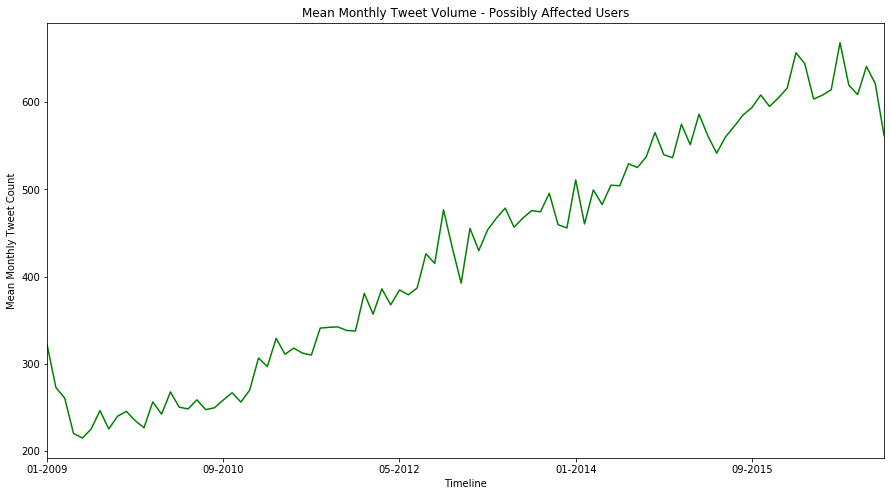

In [25]:
plt.figure()
tweet_countDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Mean Monthly Tweet Volume - Possibly Affected Users')
# plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Tweet Count')
plt.xlabel('Timeline')
plt.savefig('PAU_graphics/INF_UNRES_tweetcount.png')
plt.show()

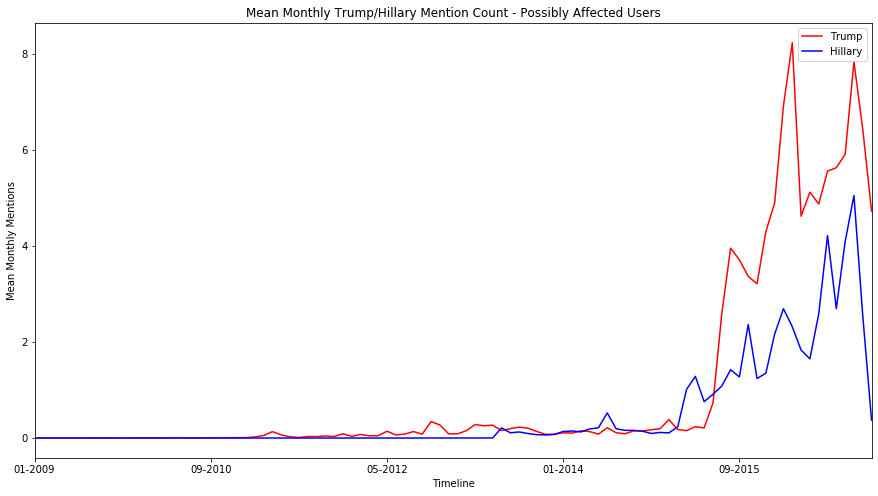

In [26]:
plt.figure()
trump_countDF.mean().plot(kind='line', color='red', figsize=(15,8),title='Mean Monthly Trump/Hillary Mention Count - Possibly Affected Users')
clinton_countDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Mentions')
plt.savefig('PAU_graphics/INF_UNRES_mentions.png')
plt.xlabel('Timeline')
plt.show()

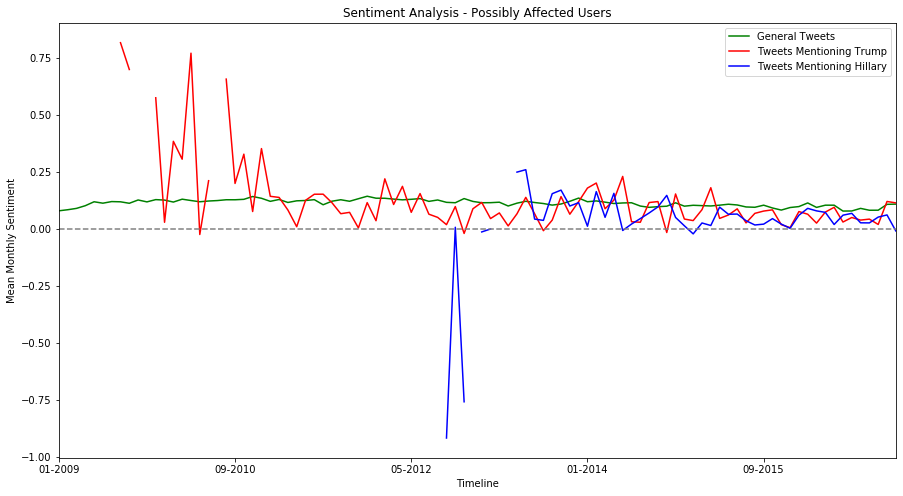

In [27]:
plt.figure()
sentiment_scoresDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Sentiment Analysis - Possibly Affected Users')
trump_sentDF.mean().plot(kind='line', color='red', figsize=(15,8))
clinton_sentDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('General Tweets','Tweets Mentioning Trump','Tweets Mentioning Hillary'))
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel('Mean Monthly Sentiment')
plt.savefig('PAU_graphics/INF_UNRES_sentiment.png')
plt.xlabel('Timeline')
plt.show()